### Sudoku

&nbsp;

Sudoku is a logic-based, combinatorial number-placement puzzle. Despite its Japanese name, the game was actually invented by an American and later gained popularity in Japan. 

There are many ways (e.g. graph coloring) for computer algorithms to solve Sudoku. Here we use Binary Integer Linear Programming to solve the puzzle via convex optimization. In this particular optimization problem, we have no objective function to maximize or minimize. We merely need to satisfy the constraints below.

1. Only one element in each column
2. Only one element in each row
3. Only one element in each sub matrix
4. Each cell in the matrix should be filled
5. Given elements in the cells are set on

The trick is to convert an N by N Sudoku matrix into a flattened array `x` of length N^3. Each element inside the array represents the existence of number N in the cell (N,N). To use `cvxopt` to solve the problem, we just need to create constraint matrix `A` to put everything mentioned above in the form of `Ax=b`.

More details can be found in the original paper

https://pdfs.semanticscholar.org/1ca8/21d0145e3f7b02e37e283042b4e601bf388d.pdf

Reference to graph coloring for Sudoku

https://github.com/je-suis-tm/graph-theory/blob/master/sudoku.ipynb

In [1]:
import numpy as np
import cvxopt.glpk
import matplotlib.pyplot as plt
import matplotlib.patches as patches

### functions

In [2]:
#the constraint of given elements
#set given elements in the matrix as one
def get_given_constraint(puzzle,num):

    #initialize
    given_constraint=np.zeros((len(puzzle[puzzle!=0]),num**3))

    #flatten the puzzle and find out its index inside the array
    indices=[ind+(val-1)*(num**2) for ind,val in enumerate(puzzle.ravel()) if val!=0]

    #the constraint of given elements
    for ind,val in enumerate(indices):
        given_constraint[ind,val]=1
        
    return given_constraint

In [3]:
#only one element in each column
#the summation of each column for each element should be one
def get_col_constraint(num):

    #initialize
    col_constraint=np.zeros((num**2,num**3))

    #only one element in each column
    for element_ind in range(num):
        start=element_ind*(num**2)
        end=(element_ind+1)*(num**2)
        for col_ind in range(num):
            for cell_ind in range(start+col_ind,end,num):
                col_constraint[element_ind*num+col_ind][cell_ind]=1
                
    return col_constraint

In [4]:
#only one element in each row
#the summation of each row for each element should be one
def get_row_constraint(num):

    #initialize
    row_constraint=np.zeros((num**2,num**3))

    #only one element in each row
    for itr in range(num**2):
        for cell_ind in range(num*itr,num*(itr+1)):
                row_constraint[itr][cell_ind]=1
                
    return row_constraint

In [5]:
#only one element in each submatrix
#the summation of each submatrix for each element should be one
#this function gets overly complicated by five layers of loops
#the actual execution should be really fast
#as some of the loops merely create the submatrix coordinates
def get_sub_constraint(num):
    
    subnum=int(num**0.5)

    #initialize
    sub_constraint=np.zeros((num**2,num**3))

    #only one element in each submatrix
    for element_ind in range(num):
        start=element_ind*(num**2)
        end=(element_ind+1)*(num**2)       
        for col_ind in range(0,num,subnum):
            for row_ind in range(0,num,subnum):
                h_samples=[i for i in range(col_ind,col_ind+subnum)]
                v_samples=[i for i in range(row_ind,row_ind+subnum)]
                for v_index,v_pointer in enumerate(v_samples):
                    for h_index,h_pointer in enumerate(h_samples):
                        cell_ind=start+v_pointer*num+h_pointer
                        sub_constraint[element_ind*num+int(col_ind/subnum)+row_ind][cell_ind]=1
                        
    return sub_constraint

In [6]:
#each cell must be filled
#the summation of each cell for different elements should be one
def get_must_constraint(num):

    #initialize
    must_constraint=np.zeros((num**2,num**3))

    #each cell must be filled
    for must_ind in range(num**2):
        must_constraint[must_ind][must_ind::num**2]=1
        
    return must_constraint

In [7]:
#use cvxopt integer linear programming
#the answer may not be unique
#depends on sudoku itself
def solve(constraints):    
    
    #equality constraints
    #the only thing that matters
    equality_coeff=cvxopt.matrix(constraints)
    equality_value=cvxopt.matrix(np.ones(constraints.shape[0]))
    
    #linear coefficient
    #no objective function to maximize
    linear_coeff=cvxopt.matrix(np.zeros(constraints.shape[1]))
    
    #inequality constraints
    inequality_coeff=cvxopt.matrix(np.zeros(constraints.shape))
    inequality_value=cvxopt.matrix(np.zeros(constraints.shape[0]))    
    
    #binary constraints
    #the constraint should cover the whole length of vector x
    #the default is (0,1) and u cannot alter it
    binary_set=set(range(constraints.shape[1]))
    
    #result
    status,solution=cvxopt.glpk.ilp(
        c=linear_coeff,G=inequality_coeff,h=inequality_value,
        A=equality_coeff,b=equality_value,
        B=binary_set)
    
    return status,solution

In [8]:
#create output
#convert flatten matrix to a regular n by n matrix
def extract_solution(solution,num):

    #initialize
    sudoku=np.zeros((num,num))

    #revert flatten matrix to real sudoku
    for i in range(num):
        submatrix=np.array(solution[i*(num**2):(i+1)*(num**2)]).reshape(num,num)
        for j in np.column_stack(np.where(submatrix==1)):
            sudoku[j[0],j[1]]=i+1
            
    return sudoku

In [9]:
#main function
#all combined into one
def sudoku_ans(puzzle):

    #get the level of sudoku
    num=puzzle.shape[0]
    
    #create constraints
    col_constraint=get_col_constraint(num)
    row_constraint=get_row_constraint(num)
    sub_constraint=get_sub_constraint(num)
    must_constraint=get_must_constraint(num)
    given_constraint=get_given_constraint(puzzle,num)

    #aggregate
    constraints=np.vstack((col_constraint,row_constraint,
               sub_constraint,must_constraint,
               given_constraint))

    #solve via ilp and create output
    status,solution=solve(constraints)
    sudoku=extract_solution(solution,num)
    
    return sudoku

In [10]:
#viz sudoku
def viz(sudoku,colors):

    ax=plt.figure(figsize=(5,5)).add_subplot(111)
    
    #plot blocks with graph coloring
    for latitude in range(sudoku.shape[0]):
        for longitude in range(sudoku.shape[1]):
            ax.add_patch(patches.Rectangle((latitude,longitude),
                    1,1,facecolor=colors[sudoku[latitude][longitude]],
                                           edgecolor='k',fill=True))

    #show answers
    for latitude in range(sudoku.shape[0]):
        for longitude in range(sudoku.shape[1]):
            plt.text(latitude+0.5,longitude+0.5,
                     str(sudoku[latitude][longitude]),
                     ha='center',va='center',fontsize=20)

    plt.xlim((0,sudoku.shape[0]))
    plt.ylim((0,sudoku.shape[1]))
    plt.xticks([])
    plt.yticks([])
    plt.show()

### run

In [11]:
easy=np.array([
[0,0,2, 0],
[0,0,0, 0],
[0,1,0, 0],
[4,0,0, 2]])

In [12]:
easy_ans=sudoku_ans(easy)

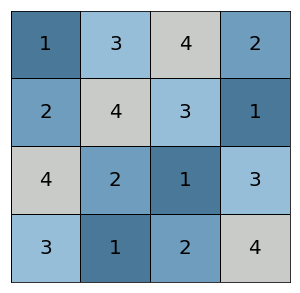

In [13]:
viz(easy_ans.astype(int),
    {1: '#4a7899',
 2: '#6f9dbd',
 3: '#97bed9',
 4: '#c9cbc9'})

In [14]:
medium=np.array([
[0,0,7, 8,0,5, 2,0,0],
[8,0,0, 6,0,4, 0,0,5],
[0,1,0, 0,9,0, 0,8,0],
[4,0,0, 2,8,9, 0,0,7],
[0,0,0, 0,0,0, 0,0,0],
[5,0,0, 7,6,1, 0,0,2],
[0,7,0, 0,3,0, 0,6,0],
[3,0,0, 1,0,6, 0,0,4],
[0,0,2, 5,0,8, 1,0,0]])

In [15]:
medium_ans=sudoku_ans(medium)

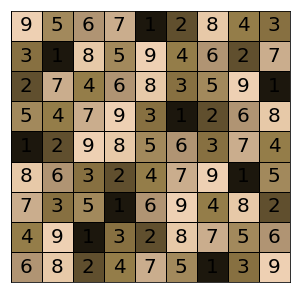

In [16]:
viz(medium_ans.astype(int),
    {1: '#1c170d',
 2: '#604f2e',
 3: '#877041',
 4: '#947d49',
 5: '#a2895c',
 6: '#b09473',
 7: '#caad8d',
 8: '#e7c9a8',
 9: '#eed0b3'})

In [17]:
hard=np.array([
[7,0,0, 0,0,0, 4,0,0],
[0,2,0, 0,7,0, 0,8,0],
[0,0,3, 0,0,8, 0,0,9],
[0,0,0, 5,0,0, 3,0,0],
[0,6,0, 0,2,0, 0,9,0],
[0,0,1, 0,0,7, 0,0,6],
[0,0,0, 3,0,0, 9,0,0],
[0,3,0, 0,4,0, 0,6,0],
[0,0,9, 0,0,1, 0,0,5]])

In [18]:
hard_ans=sudoku_ans(hard)

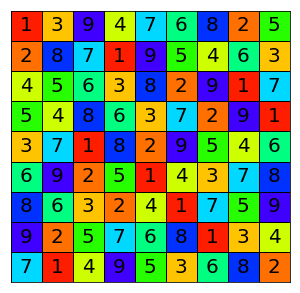

In [19]:
viz(hard_ans.astype(int),
    {1: '#ff1d00',
 2: '#ff7000',
 3: '#ffc400',
 4: '#ceff00',
 5: '#27ff00',
 6: '#00ff80',
 7: '#00d8ff',
 8: '#0031ff',
 9: '#4000ff'})